In [2]:
import glob
import os
import cv2
import glob
import re
import json
import h5py

import matplotlib as mpl
import tifffile as tf
import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy import misc,interpolate,stats,signal
import pandas as pd
import pickle as pkl
import importlib

In [3]:
%matplotlib notebook

In [4]:
import analyze2p.utils as hutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.plotting as pplot

# Source data paths

In [5]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

# Select 2p dataset

In [472]:
#print(animalid)
# session_2p = '20190622' #'20191111'
# retinorun_2p='retino_run1'
# animalid = 'JC084'
# session_2p = '20190522' #'20191111'

traceid='traces001'


# datakey = '20190617_JC097_fov1'
# visual_area = 'V1'
# retinorun_2p='retino_run1'

# datakey='20190603_JC080_fov1'
# visual_area='Lm'
# retinorun_2p='retino_run1'

datakey='20191006_JC110_fov1'
visual_area = 'V1'
retinorun_2p='retino_run1'

In [473]:
# Load FFT data 
use_pixels=False

retinoid, RETID = retutils.load_retino_analysis_info(
                    datakey, run=retinorun_2p, use_pixels=use_pixels)
retinorun_2p = os.path.split(RETID['DST'].split('/retino_analysis')[0])[-1]
# print("Current run: %s" % retinorun_2p)
data_id = '_'.join([datakey, retinorun_2p, retinoid])
print("DATA ID: %s" % data_id)
scaninfo = retutils.get_protocol_info(datakey, run=retinorun_2p)

# Set animal output dir
animal_dst_dir = os.path.join(RETID['DST'], 'visualization')
if use_pixels:
    magratios_soma, phases_soma, trials_by_cond = fft_results_by_trial(RETID)
else:
    trials_by_cond=None
    fft_results = retutils.load_fft_results(datakey,
                                    retinorun=retinorun_2p, traceid=traceid, 
                                    rootdir=rootdir, create_new=False,
                                    use_pixels=use_pixels)
    fft_soma = fft_results['fft_soma']
    fft_np = fft_results['fft_neuropil']
    # Create dataframe of magratios -- each column is a condition
    magratios_soma, phases_soma = retutils.extract_from_fft_results(fft_soma)
    magratios_np, phases_np = retutils.extract_from_fft_results(fft_np)
    

DATA ID: 20191006_JC110_fov1_retino_run1_analysis002


In [474]:
# Image dimensions
d2_orig = scaninfo['pixels_per_line']
d1_orig = scaninfo['lines_per_frame']
print("Original dims: [%i, %i]" % (d1_orig, d2_orig))
ds_factor = int(RETID['PARAMS']['downsample_factor'])
print('Data were downsampled by %i.' % ds_factor)

# Get pixel size
pixel_size = hutils.get_pixel_size()
pixel_size_ds = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)
d1 = int(d1_orig/ds_factor)
d2 = int(d2_orig/ds_factor)
print(d1, d2)

Original dims: [512, 512]
Data were downsampled by 2.
256 256


In [475]:
magthr_2p=0.001
delay_map_thr=1.0
# #### Get maps
# abs_vmin, abs_vmax = (-np.pi, np.pi)
df = retutils.get_final_maps(magratios_soma, phases_soma, 
                    trials_by_cond=trials_by_cond,
                    mag_thr=magthr_2p, dims=(d1_orig, d2_orig), 
                    ds_factor=ds_factor, use_pixels=use_pixels)
print(df.shape)
df.head()
roi_list = df.dropna().index.tolist()

(391, 4)


In [476]:
magratios_soma.head()

,blank,left,right,bottom,top
0,0.010566,0.036728,0.028020,0.026903,0.028706
1,0.005706,0.007408,0.010512,0.014947,0.017336
2,0.002860,0.017132,0.010803,0.011000,0.012620
3,0.003240,0.023437,0.014282,0.012049,0.009388
4,0.001944,0.029600,0.056976,0.042853,0.025006


In [477]:
df_neuropil = retutils.get_final_maps(magratios_np, phases_np, trials_by_cond=trials_by_cond,
                    mag_thr=magthr_2p, dims=(d1_orig, d2_orig), ds_factor=ds_factor, use_pixels=use_pixels)
print(df_neuropil.shape)
df_neuropil.head()

(391, 4)


,phase_az,phase_el,mag_az,mag_el
0,2.003493,-0.027228,0.059477,0.048677
1,2.033606,0.027155,0.059414,0.045290
2,1.966183,0.004154,0.069301,0.056175
3,1.868249,-0.026057,0.080956,0.059540
4,1.909748,-0.022632,0.074790,0.055679


In [478]:
%matplotlib notebook

<IPython.core.display.Javascript object>


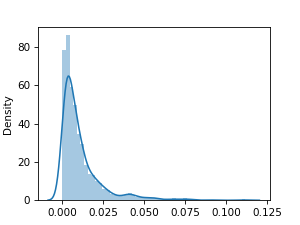

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

In [479]:
pl.figure(figsize=(4,3))
sns.distplot(magratios_soma.dropna().values.ravel())

In [480]:
# zimg = load_fov_image(RETID)
# d1_2p, d2_2p = zimg.shape

## Load masks

In [481]:
# Get masks
session_2p, animalid, fovnum = hutils.split_datakey_str(datakey)
analysis_dir = RETID['DST']
roiid = RETID['PARAMS']['roi_id']
retino_dpath = os.path.join(analysis_dir, 'traces', 'extracted_traces.h5')
tfile = h5py.File(retino_dpath, 'r')

rid_fpath = glob.glob(os.path.join(rootdir, animalid, session_2p, 'ROIs', 'rids*.json'))[0]
with open(rid_fpath, 'r') as f:
    rids = json.load(f)
reffile = rids[roiid]['PARAMS']['options']['ref_file']
print( tfile['File%03d' % int(reffile)].keys())

# Get neuropil masks (for background calculation)
masks_np = tfile['File%03d' % int(reffile)]['np_masks'][:].T
nrois_total, _ = masks_np.shape
masks_np = np.reshape(masks_np, (nrois_total, d1, d2))
masks_np[masks_np>0] = 1
print("NP masks:", masks_np.shape)
# Get soma masks
masks_soma = tfile['File%03d' % int(reffile)]['masks'][:].copy()
masks_soma = np.reshape(masks_soma, (nrois_total, d1, d2))
masks_soma[masks_soma>0] = 1
print(masks_soma.shape)


<KeysViewHDF5 ['corrected', 'masks', 'neuropil', 'np_masks', 'processed', 'raw']>
NP masks: (391, 256, 256)
(391, 256, 256)


#### Dilate masks

In [482]:
um_per_pixel = np.mean(pixel_size)
desired_radius_um = 20.0 # 20.
pixels2dilate = desired_radius_um/um_per_pixel
print(pixels2dilate)
kernel_size = np.ceil(pixels2dilate+2) #21
kernel = retutils.get_kernel(kernel_size)

kernel_diam_um = (kernel.shape[0]*um_per_pixel)
print("Dilation diameter (um): %.2f" % kernel_diam_um)

dilated_masks = retutils.dilate_mask_centers(masks_soma.astype(float), kernel_size=kernel_size)

9.523809523809526
Dilation diameter (um): 23.10


<IPython.core.display.Javascript object>


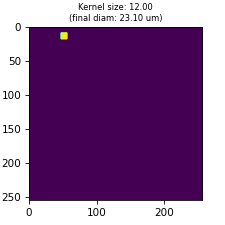

10
10


In [483]:
rid = 4
pl.figure(figsize=(3,3))
pl.imshow(dilated_masks[rid, :, :])
pl.title("Kernel size: %.2f\n(final diam: %.2f um)" \
         % (kernel_size, kernel_diam_um), fontsize=8)
x, y = np.where(dilated_masks[rid, :, :]>0)
print(x.max()-x.min())
print(y.max()-y.min())

#### PHASE to roi masks

In [492]:
abs_vmin, abs_vmax = (-np.pi, np.pi)
average_overlap=True
#### Neuropil masks
azim_phase_np, elev_phase_np = retutils.get_phase_masks(dilated_masks, 
                                df_neuropil['phase_az'], df_neuropil['phase_el'], 
                                average_overlap=average_overlap, roi_list=None)

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py:924: RuntimeWarning: Mean of empty slice
  avg_mask = tmpmask.copy().ravel()


In [493]:
# Get pixel size
pixel_size = hutils.get_pixel_size()
pixel_size_ds = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)
d1 = int(d1_orig/ds_factor)d
d2 = int(d2_orig/ds_factor)
print(d1, d2)

256 256


In [494]:
#### Neuropil:  Transform 2p fov
azim_phase_np_r = retutils.transform_2p_fov(azim_phase_np, pixel_size_ds, normalize=False)
elev_phase_np_r = retutils.transform_2p_fov(elev_phase_np, pixel_size_ds, normalize=False)
print(azim_phase_np_r.shape)

(1177, 972)


In [495]:
#### Transform all masks to get CENTROIDs
# This is to replace 'azim_phase_soma' stuff, bec
# better control of visualization for scatterplot
nrois_total = masks_soma.shape[0]
masks_r0 = np.dstack([retutils.transform_2p_fov(dilated_masks[i, :], 
                     pixel_size_ds, normalize=False) \
                     for i in range(nrois_total)]).T
masks_r = np.swapaxes(masks_r0, 1, 2) # [nrois, d1/rows/y, d2/cols]
print("Reshaped masks: %s" % str(masks_r.shape))


Reshaped masks: (391, 1177, 972)


In [496]:
#importlib.reload(roiutils)
from analyze2p.extraction import rois as roiutils

In [497]:
importlib.reload(roiutils)

<module 'analyze2p.extraction.rois' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/extraction/rois.py'>

In [498]:
centroids = roiutils.get_roi_centroids(masks_r, xlabel='ml_pos', ylabel='ap_pos')
centroids.head()

,ap_pos,ml_pos
0,880.0,952.0
1,912.0,912.0
2,917.0,928.0
3,967.0,912.0
4,944.0,916.0


In [499]:
retinodf = pd.concat([centroids, df], axis=1)
print(retinodf.shape)
retinodf.head()

(391, 6)


,ap_pos,ml_pos,phase_az,phase_el,mag_az,mag_el
0,880.0,952.0,1.755200,-0.063843,0.032374,0.027805
1,912.0,912.0,NaN,NaN,0.008960,0.016142
2,917.0,928.0,1.814990,0.213110,0.013967,0.011810
3,967.0,912.0,1.901386,0.011366,0.018860,0.010719
4,944.0,916.0,1.748735,-0.156081,0.043288,0.033929


In [500]:
magthr_2p=0.01
pass_mag_rois = retinodf[(retinodf.mag_az>magthr_2p) 
                      & (retinodf.mag_el>magthr_2p)].index.tolist()
print(retinodf.shape, retinodf.loc[pass_mag_rois].shape)

(391, 6) (137, 6)


In [501]:
#### Load ROI image (std activity map)
imgs = glob.glob(os.path.join('%s*' % RETID['SRC'], 'std_images.tif'))[0]
orig_zimg = tf.imread(imgs)
orig_zimg = orig_zimg.mean(axis=0)
zimg_r = retutils.transform_2p_fov(orig_zimg, pixel_size)
print(zimg_r.shape)

(1177, 972)


# Plot dilated Neuropil masks + Soma 

<IPython.core.display.Javascript object>


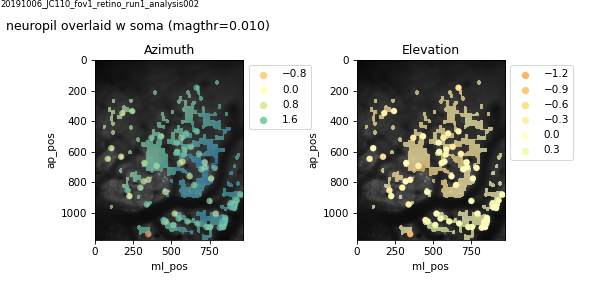

/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_5ae341/visualization _sanitycheck_centroids_vs_neuropil_masks


In [503]:
cmap='Spectral' #pl.get_cmap('cmr.rainforest')
plot_neuropil=True
lw=0.1
np_alpha=0.7

mask_str='neuropil' if plot_neuropil else 'soma'
normalize = mpl.colors.Normalize(vmin=abs_vmin, vmax=abs_vmax)
# cmap = sns.color_palette('nipy_spectral')

fig, axn = pl.subplots(1, 2, figsize=(8,4))
ax = axn[0]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
if plot_neuropil:
    ax.imshow(azim_phase_np_r, cmap=cmap, vmin=abs_vmin, vmax=abs_vmax, 
              alpha=np_alpha)
else:
    ax.imshow(azim_phase_soma_r, cmap=cmap, vmin=abs_vmin, vmax=abs_vmax, 
              alpha=alpnp_alphaha)
sns.scatterplot(x='ml_pos', y='ap_pos', data=retinodf.loc[pass_mag_rois], 
                hue='phase_az', ax=ax, palette=cmap, alpha=0.7, hue_norm=normalize,
                linewidth=lw, edgecolors='k')
ax.set_title("Azimuth")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax = axn[1]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
if plot_neuropil:
    ax.imshow(elev_phase_np_r, cmap=cmap, vmin=abs_vmin, vmax=abs_vmax, 
              alpha=np_alpha)
else:
    ax.imshow(elev_phase_soma_r, cmap=cmap, vmin=abs_vmin, vmax=abs_vmax, 
              alpha=np_alpha)
sns.scatterplot(x='ml_pos', y='ap_pos', data=retinodf.loc[pass_mag_rois], 
                hue='phase_el', ax=ax, palette=cmap, alpha=1, hue_norm=normalize,
                linewidth=lw, edgecolors='k')
ax.set_title("Elevation")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fig.text(0.01, 0.9, '%s overlaid w soma (magthr=%.3f)' \
                 % (mask_str, magthr_2p), fontsize=12)

pplot.label_figure(fig, data_id)
figname = '_sanitycheck_centroids_vs_%s_masks' % mask_str
pl.savefig(os.path.join(animal_dst_dir, '%s.svg' % figname)) 

print(animal_dst_dir, figname)

In [504]:
len(roi_list)

137

In [505]:
del masks_soma
del dilated_masks
del masks_r

In [506]:
screen2p_x = 119.5564
screen2p_y = 67.323
resolution2p = [1920, 1080] #[1024, 768]

lmax_az_2p = screen2p_x #/2.
lmin_az_2p = 0 #-screen2p_x #-lmax_az_2p
lmax_el_2p = screen2p_y #/2.
lmin_el_2p = 0 #-screen2p_y# 0 #-lmax_el_2p

# lmax_az_2p = screen2p_x/2.
# lmin_az_2p = -lmax_az_2p
# lmax_el_2p = screen2p_y/2.
# lmin_el_2p = -lmax_el_2p

In [507]:
smooth_fwhm = 91 #21
#azim_smoothed = smooth_array(azim_smoothed, smooth_fwhm, phaseArray=True)
azim_smoothed = retutils.smooth_neuropil(azim_phase_np_r, smooth_fwhm=smooth_fwhm)
elev_smoothed = retutils.smooth_neuropil(elev_phase_np_r, smooth_fwhm=smooth_fwhm)

azi_2p_np = hutils.convert_range(azim_smoothed, newmin=lmin_az_2p, newmax=lmax_az_2p,
                          oldmin=abs_vmin, oldmax=abs_vmax)
el_2p_np = hutils.convert_range(elev_smoothed, newmin=lmin_az_2p, newmax=lmax_az_2p, 
                         oldmin=abs_vmin, oldmax=abs_vmax)

In [508]:
retinodf['az_lin'] = hutils.convert_range(retinodf['phase_az'], newmin=lmin_az_2p, newmax=lmax_az_2p, 
                                   oldmin=abs_vmin, oldmax=abs_vmax)
retinodf['el_lin'] = hutils.convert_range(retinodf['phase_el'], newmin=lmin_az_2p, newmax=lmax_az_2p, 
                                   oldmin=abs_vmin, oldmax=abs_vmax)

retinodf['az_lin_centered'] = retinodf['az_lin'] - (lmax_az_2p/2.)
retinodf['el_lin_centered'] = retinodf['el_lin'] - (lmax_az_2p/2.)

#### Save processed results as dataframe

In [509]:
retinorun_dir = RETID['DST'].split('/analysis0')[0]
print(retinorun_dir)

/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/retino_run1/retino_analysis


In [510]:
roi_retino_file = os.path.join(retinorun_dir, 'analysis_%s.pkl' % roiid)

R = {'azi_np': azi_2p_np, 'el_np': el_2p_np, 'retinodf': retinodf,
    'lmin_az': lmin_az_2p, 'lmax_az': lmax_az_2p,
    'lmin_el': lmin_el_2p, 'lmax_el': lmax_el_2p}

with open(roi_retino_file, 'wb') as f:
    pkl.dump(R, f, protocol=2)
print(roi_retino_file)

/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis_rois001.pkl


<IPython.core.display.Javascript object>


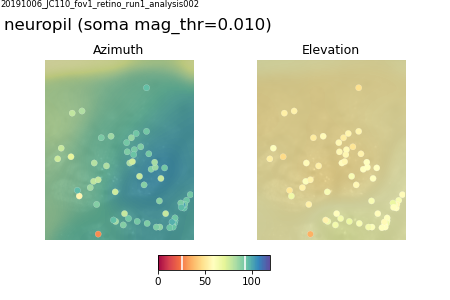

/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_5ae341/visualization _smoothed_np_retino_with_centroids_LIN


In [511]:
# Plot NEUROPIL and ROI overlay
plot_rois = pass_mag_rois # roi_list

vmin = lmin_az_2p
vmax = lmax_az_2p
np_alpha=0.8
lw=0.15
normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

fig, axn = pl.subplots(1, 2, figsize=(6,4))
ax = axn[0]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
ax.imshow(azi_2p_np, cmap=cmap, vmin=vmin, vmax=vmax, alpha=np_alpha)
sns.scatterplot(x='ml_pos', y='ap_pos', data=retinodf.loc[plot_rois], 
                hue='az_lin', ax=ax, palette=cmap, alpha=1, hue_norm=normalize,
                linewidth=lw, edgecolors='k')
ax.set_title("Azimuth")
ax.legend_.remove()

ax = axn[1]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
im = ax.imshow(el_2p_np, cmap=cmap, vmin=vmin, vmax=vmax, alpha=np_alpha)
sns.scatterplot(x='ml_pos', y='ap_pos', data=retinodf.loc[plot_rois], 
                hue='el_lin', ax=ax, palette=cmap, alpha=1, hue_norm=normalize,
                linewidth=lw, edgecolors='k')
ax.set_title("Elevation")
ax.legend_.remove()

pl.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.8, wspace=0.1)
fig.text(0.01, 0.9, '%s (soma mag_thr=%.3f)' % (mask_str, magthr_2p), fontsize=16)

cb = fig.add_axes([0.35, 0.1, 0.25, 0.05])
pl.colorbar(im, cax=cb, orientation='horizontal')
ab_max_az = max([abs(lmax_az_2p), abs(lmin_az_2p)])
ab_max_el = max([abs(lmin_el_2p), abs(lmax_el_2p)])
screen_lim_pos = ab_max_el/ab_max_az #(lmax_alt-screen_h_max)/(lmax_alt*2.)
if abs(round(lmin_az_2p))==abs(round(lmax_az_2p)):#<0: # Center is 0
    cb.axvline(x=screen_lim_pos*lmax_az_2p, color='w') # my data is between 0 and 1
    cb.axvline(x=screen_lim_pos*lmin_az_2p, color='w') # my data is between 0 and 1
else: # min=0, max=120
    c_min, cmax = cb.get_xlim()
    screen_midp = (ab_max_az/2.)
    cb.axvline(x=screen_midp+(screen_lim_pos*ab_max_az)/2., color='w') # my data is between 0 and 1
    cb.axvline(x=screen_midp-(screen_lim_pos*ab_max_az)/2., color='w') # my data is between 0 and 1
#cb.axvline(x=0, color='w')

for ax in axn.flat:
    ax.axis('off')
pplot.label_figure(fig, data_id)
figname = '_smoothed_np_retino_with_centroids_LIN'
pl.savefig(os.path.join(animal_dst_dir, '%s.svg' % figname)) 

print(animal_dst_dir, figname)

## Scatter

In [512]:
retinodf.head()

,ap_pos,ml_pos,phase_az,phase_el,mag_az,mag_el,az_lin,el_lin,az_lin_centered,el_lin_centered
0,880.0,952.0,1.755200,-0.063843,0.032374,0.027805,93.176122,58.563391,33.397922,-1.214809
1,912.0,912.0,NaN,NaN,0.008960,0.016142,NaN,NaN,NaN,NaN
2,917.0,928.0,1.814990,0.213110,0.013967,0.011810,94.313813,63.833260,34.535613,4.055060
3,967.0,912.0,1.901386,0.011366,0.018860,0.010719,95.957756,59.994469,36.179556,0.216269
4,944.0,916.0,1.748735,-0.156081,0.043288,0.033929,93.053114,56.808283,33.274914,-2.969917


In [513]:
# Load projection info
# --------------------------------------------------
# retinodf['ml_proj'] = ''
# retinodf['ap_proj'] = ''
proj_results = 'vectors'
fpaths = [f for f in glob.glob(os.path.join(rootdir, animalid, 
            session_2p, 'FOV%i_*' % fovnum, retinorun_2p, 
            'retino_analysis/retino_structure', 
            '%s_*.pkl' % (proj_results))) if '_pixels_thr' not in f] 
for fp in fpaths:
    print(fp)

/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/retino_run1/retino_analysis/retino_structure/vectors_V1.pkl


In [514]:
fpath = fpaths[0]
with open(fpath, 'rb') as f:
    gvectors = pkl.load(f, encoding='latin1')
gvectors.keys()

dict_keys(['el', 'az'])

In [515]:
gvectors

{'el': array([0.34322318, 0.93925388]), 'az': array([0.94081586, 0.33891815])}

In [516]:
# Project FOV coordinates
retinodf['ml_proj'] = np.array([np.dot(np.array((ml, ap)), abs(gvectors['az'])) \
                            for ml, ap in retinodf[['ml_pos', 'ap_pos']].values])

retinodf['ap_proj'] = np.array([np.dot(np.array((ml, ap)), gvectors['el']) \
                            for ml, ap in retinodf[['ml_pos', 'ap_pos']].values])

#### Compare TRUE coord vs. Gradient-Projected coords

<IPython.core.display.Javascript object>


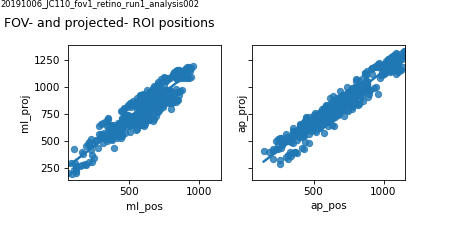

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.01, 0.88, 'FOV- and projected- ROI positions')

In [517]:
fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
ax=axn[0]
sns.regplot('ml_pos', 'ml_proj', data=retinodf, ax=ax)
ax=axn[1]
sns.regplot('ap_pos', 'ap_proj', data=retinodf, ax=ax)
pl.subplots_adjust(bottom=0.2, top=0.8, left=0.15, right=0.9)
# ax=axn[1,0]
# sns.regplot('x', 'az_lin', data=retinodf, ax=ax)
# ax=axn[1,1]
# sns.regplot('y', 'el_lin', data=retinodf, ax=ax)
pplot.label_figure(fig, data_id)
fig.text(0.01, 0.88, 'FOV- and projected- ROI positions', fontsize=12)

#### Compare with RF estimated metrics

In [518]:
import analyze2p.aggregate_datasets as aggr
import analyze2p.receptive_fields.utils as rfutils
visual_areas=['V1', 'Lm', 'Li']
experiment='retino'

In [519]:
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()
# all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                if not meta.query('@va == visual_area and @dk == datakey').empty])

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets


In [520]:
# Load RF data
do_spherical_correction=False
# Get cells and metadata
assigned_cells, rf_meta = aggr.select_assigned_cells(cells0, sdata, 
                                                experiments=['rfs', 'rfs10']) 
# Load RF fit data
rf_fit_desc = rfutils.get_fit_desc(response_type='dff', 
                                 do_spherical_correction=do_spherical_correction)
rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, fit_desc=rf_fit_desc,
                                 reliable_only=False)
# Combined rfs5/rfs10
avg_rfs = rfutils.average_rfs(rfdata)
rfdf = avg_rfs[(avg_rfs.visual_area==visual_area) & (avg_rfs.datakey==datakey)].copy()
rfdf = aggr.add_roi_positions(rfdf)

N dpaths: 62, N unfit: 0
N datasets included: 62, N sessions excluded: 4
Adding ROI position info...


In [521]:
# Project FOV coordinates again
# This is equivalent to retinodf[['x', 'y']]

rfdf['ml_proj'] = np.array([np.dot(np.array((ml, ap)), abs(gvectors['az'])) \
                            for ml, ap in rfdf[['ml_pos', 'ap_pos']].values])

rfdf['ap_proj'] = np.array([np.dot(np.array((ml, ap)), gvectors['el']) \
                            for ml, ap in rfdf[['ml_pos', 'ap_pos']].values])

In [522]:
# Get cells common to MOVINGBAR and RFS
rf_cells = rfdf[rfdf['cell'].isin(pass_mag_rois)]['cell'].unique()
retino_cells = np.copy(pass_mag_rois)
common = np.intersect1d(rf_cells, retino_cells)

rfs = rfdf[rfdf['cell'].isin(common)].copy().sort_values(by='cell')
rfs.index = rfs['cell'].values
rets = retinodf.loc[common].copy().loc[rfs['cell'].values]
print(rets.shape, rfs.shape)
# plotdf = pd.concat([rets, rfs], axis=1)
# print(rets.shape, rfs.shape, plotdf.shape)

(31, 12) (31, 36)


In [523]:
%matplotlib notebook

<IPython.core.display.Javascript object>


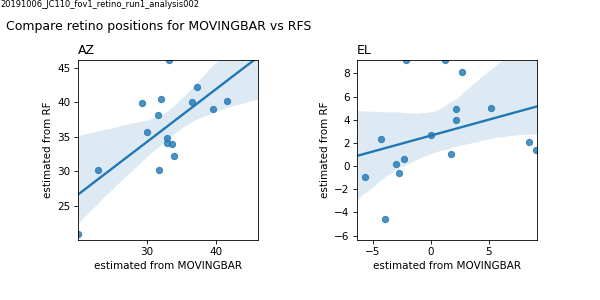

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.01, 0.9, 'Compare retino positions for MOVINGBAR vs RFS')

In [524]:
# Compare retino position estimates for MOVINGBAR and RF
fig, axn = pl.subplots(1,2, figsize=(8,4))
ax=axn[0]
ax.set_aspect('equal')
ax.set_title('AZ', loc='left')
xmin = min([rfs['x0'].min(), rets['az_lin_centered'].min()])
xmax = max([rfs['x0'].max(), rets['az_lin_centered'].max()])
ax.set_xlim([xmin, xmax])
ax.set_ylim([xmin, xmax])
sns.regplot(rets['az_lin_centered'], rfs['x0'], ax=ax, truncate=False)
ax.set_xlabel('estimated from MOVINGBAR')
ax.set_ylabel('estimated from RF')

ax=axn[1]
ax.set_aspect('equal')
ax.set_title('EL', loc='left')
xmin = min([rfs['y0'].min(), rets['el_lin_centered'].min()])
xmax = max([rfs['y0'].max(), rets['el_lin_centered'].max()])
ax.set_xlim([xmin, xmax])
ax.set_ylim([xmin, xmax])
sns.regplot(rets['el_lin_centered'], rfs['y0'], ax=ax, truncate=False)
ax.set_xlabel('estimated from MOVINGBAR')
ax.set_ylabel('estimated from RF')

pl.subplots_adjust(wspace=0.5, bottom=0.2, top=0.8)

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.9, "Compare retino positions for MOVINGBAR vs RFS",
        fontsize=12)

In [525]:
# posdf = aggr.add_roi_positions(rfs)
# posdf.head()

In [532]:
rfs['ml_pos'].shape

(31,)

<IPython.core.display.Javascript object>


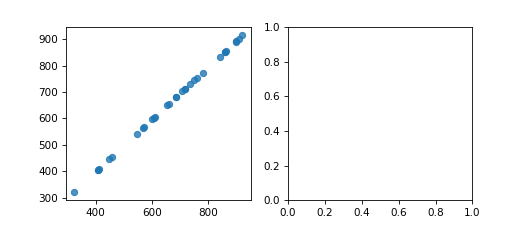

TypeError: No loop matching the specified signature and casting was found for ufunc svd_n_s

In [533]:
# Sanity check
fig, axn = pl.subplots(1,2, figsize=(7,3))
ax=axn[0]
sns.regplot(rfs['ml_pos'], rets['ml_pos'], ax=ax)
ax=axn[1]
sns.regplot(rfs['ap_pos'], rets['ap_pos'], ax=ax)
pl.subplots_adjust(bottom=0.2, wspace=0.5, top=0.8)

fig.text(0.01, 0.95, 'Sanity check\mget_roi_centroids() vs mask-based calculation for ctx position")')

In [534]:
(rfs['ml_proj'].values-rfs['ml_proj'].values).max()
(rfs['ap_proj'].values-rfs['ap_proj'].values).max()


0.0

<IPython.core.display.Javascript object>


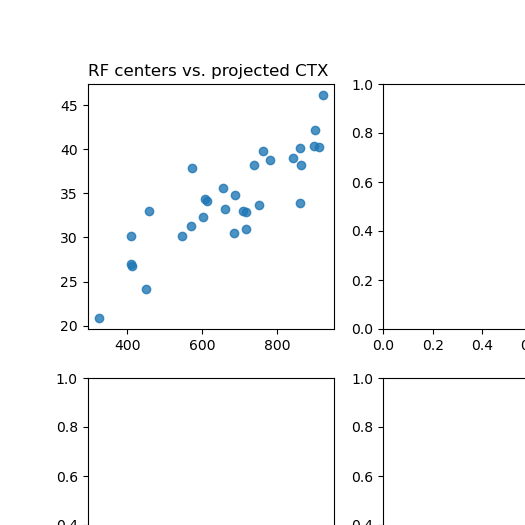

TypeError: No loop matching the specified signature and casting was found for ufunc svd_n_s

In [535]:
fig, axn = pl.subplots(2,2, figsize=(7,7))
ax=axn[0,0]
ax.set_title('RF centers vs. projected CTX', loc='left', fontsize=12)
sns.regplot(rfs['ml_pos'], rfs['x0'], ax=ax, label='ctx pos')
ax.set_ylim([5, 30])
sns.regplot(rfs['ml_proj'], rfs['x0'], ax=ax, label='projected along vec')
ax.legend()

ax=axn[0,1]
sns.regplot(rfs['ap_pos'], rfs['y0'], ax=ax)
sns.regplot(rfs['ap_proj'], rfs['y0'], ax=ax)
# pl.subplots_adjust(wspace=0.5, bottom=0.2, top=0.8)

ax=axn[1,0]
ax.set_title('MOVINGBAR centers vs. projected CTX',
            loc='left', fontsize=12)
sns.regplot(rets['ml_pos'], rets['az_lin_centered'], ax=ax, label='ctx pos')
ax.set_ylim([5, 30])
sns.regplot(rets['ml_proj'], rets['az_lin_centered'], ax=ax, 
            label='projected along vec')
ax.legend()

ax=axn[1,1]
sns.regplot(rets['ap_pos'], rets['el_lin_centered'], ax=ax)
sns.regplot(rets['ap_proj'], rets['el_lin_centered'], ax=ax)
pl.subplots_adjust(wspace=0.5, bottom=0.2, hspace=0.5, top=0.8)

pplot.label_figure(fig, data_id)

In [536]:
# Center background maps for colorbar
az_map_ctr = azi_2p_np - lmax_az_2p*0.5
el_map_ctr = el_2p_np - lmax_az_2p*0.5


<IPython.core.display.Javascript object>


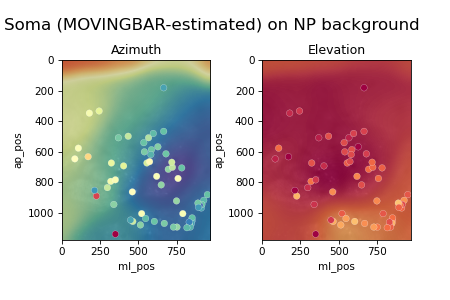

Text(0.01, 0.9, 'Soma (MOVINGBAR-estimated) on NP background')

In [537]:
vmin = min([az_map_ctr.min(), el_map_ctr.min()])
vmax = max([az_map_ctr.max(), el_map_ctr.max()])
np_alpha=0.8
lw=0.2
normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

plotd = retinodf.loc[pass_mag_rois].copy()

fig, axn = pl.subplots(1, 2, figsize=(6,4))
ax = axn[0]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
ax.imshow(az_map_ctr, cmap=cmap, vmin=vmin, vmax=vmax, alpha=np_alpha)
sns.scatterplot(x='ml_pos', y='ap_pos', data=plotd, ax=ax,
                alpha=1, hue='az_lin_centered', hue_norm=normalize, palette=cmap,
                linewidth=lw, edgecolors='k', s=40)
ax.set_title("Azimuth")
ax.legend_.remove()

ax = axn[1]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
im = ax.imshow(el_map_ctr, cmap=cmap, vmin=vmin, vmax=vmax, alpha=np_alpha)
sns.scatterplot(x='ml_pos', y='ap_pos', data=plotd, ax=ax,
                alpha=1, hue='el_lin_centered', hue_norm=normalize, palette=cmap,
                linewidth=lw, edgecolors='k', s=40)
# sns.scatterplot(x='el_proj', y='az_proj', data=retinodf.loc[plot_rois], ax=ax,
#                 alpha=1, color='k',
#                 linewidth=lw, edgecolors='k')
ax.set_title("Elevation")
ax.legend_.remove()

pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.1)
fig.text(0.01, 0.9, 'Soma (MOVINGBAR-estimated) on NP background', fontsize=16)


In [538]:
rfs.shape

(31, 36)

<IPython.core.display.Javascript object>


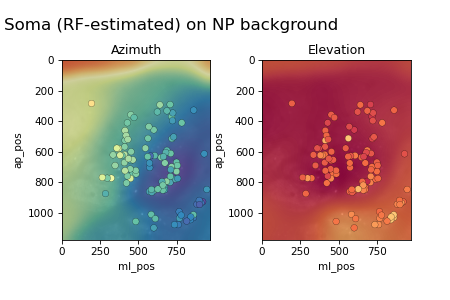

Text(0.01, 0.9, 'Soma (RF-estimated) on NP background')

In [539]:
vmin = min([az_map_ctr.min(), el_map_ctr.min()])
vmax = max([az_map_ctr.max(), el_map_ctr.max()])
np_alpha=0.8
lw=0.2
normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

plotd = rfdf.copy()
fig, axn = pl.subplots(1, 2, figsize=(6,4))
ax = axn[0]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
ax.imshow(az_map_ctr, cmap=cmap, vmin=vmin, vmax=vmax, alpha=np_alpha)
sns.scatterplot(x='ml_pos', y='ap_pos', data=plotd, ax=ax,
                alpha=1, hue='x0', hue_norm=normalize, palette=cmap,
                linewidth=lw, edgecolor='k', s=40)
ax.set_title("Azimuth")
ax.legend_.remove()

ax = axn[1]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
im = ax.imshow(el_map_ctr, cmap=cmap, vmin=vmin, vmax=vmax, alpha=np_alpha)
sns.scatterplot(x='ml_pos', y='ap_pos', data=plotd, ax=ax,
                alpha=1, hue='y0', hue_norm=normalize, palette=cmap,
                linewidth=lw, edgecolor='k', s=40)
# sns.scatterplot(x='el_proj', y='az_proj', data=retinodf.loc[plot_rois], ax=ax,
#                 alpha=1, color='k',
#                 linewidth=lw, edgecolors='k')
ax.set_title("Elevation")
ax.legend_.remove()

pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.1)
fig.text(0.01, 0.9, 'Soma (RF-estimated) on NP background', fontsize=16)


In [540]:
#### Test transformation matrix (instead of dot product)

In [541]:
importlib.reload(roiutils)

<module 'analyze2p.extraction.rois' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/extraction/rois.py'>

In [542]:
# Test case
u1 = np.array([1, 1])
u2 = np.array([-1, 1])

In [543]:
# Real thing

In [544]:
u1 = gvectors['az']
u2 = gvectors['el']
# Cartesian normal (plus error)
o1 = np.array([1, 0]) + np.finfo(np.float32).eps
o2 = np.array([0, 1]) + np.finfo(np.float32).eps
print(o1, o2)

[1.00000012e+00 1.19209290e-07] [1.19209290e-07 1.00000012e+00]


In [453]:
# dot = np.dot(o1, u1)
# cross = np.cross(o1, u1)
# ang = np.arctan2(cross, dot)
# R1 = np.array([[np.cos(ang), -np.sin(ang)], [np.sin(ang), np.cos(ang)]])

# dot = np.dot(o2, u2)
# cross = np.cross(o2, u2)
# ang = np.arctan2(cross, dot)
# R2 = np.array([[np.cos(ang), -np.sin(ang)], [np.sin(ang), np.cos(ang)]])

In [736]:
# Separately transform X, and Y from transformation matrix
def change_basis(e1, e2, retinodf, xlabel='x', ylabel='y', axis=0):
    '''
    e1, e1: vectors forming the new basis
    retinodf: pd.DataFrame() containing the x, y coords to transform
    xlabel, ylabel: column names of x, y coords in retinodf.
    axis: the axis to return (assuming nonorthogonal)
    '''
    T1 = get_transformation_matrix(e1, e2)
    transformed1 = [T1.dot(np.array([x, y])) for x, y \
                        in retinodf[[xlabel, ylabel]].values]
    new_x = np.array([p[axis] for p in transformed1])
    return new_x, T1

def predict_and_project_ctx(gvectors, rfs, xlabel='x0', ylabel='y0', axis=0):
    u1 = gvectors['az']
    u2 = gvectors['el']
    # Cartesian normal (plus error)
    o1 = np.array([1, 0]) + np.finfo(np.float32).eps
    o2 = np.array([0, 1]) + np.finfo(np.float32).eps
    # Get transformation matrix for x axis:
    if axis==0:
        T = get_transformation_matrix(u1, o2)
    else:
        T = get_transformation_matrix(o1, u2)
    transformed = [T.dot(np.array([x, y])) for x, y \
                        in rfs[[xlabel, ylabel]].values]
    # Get inverse transformation
    T_INV = np.linalg.inv(T)
    # Re-project transformed coords back to original basis
    transformed_inv = [T_INV.dot(i) for i in transformed]
    invproj_ctx_x = np.array([p[axis] for p in transformed_inv])
    
    return invproj_ctx_x


new_x, T1= change_basis(u1, o2, retinodf, axis=0)
new_y, T2 = change_basis(o1, u2, retinodf, axis=1)
    
# T1 = get_transformation_matrix(u1, o2)
# transformed1 = [T1.dot(np.array([x, y])) for x, y in retinodf[['x', 'y']].values]
# new_x = np.array([p[0] for p in transformed1])

# T2 = get_transformation_matrix(o1, u2)
# transformed2 = [T2.dot(np.array([x, y])) for x, y in retinodf[['x', 'y']].values]
# new_y = np.array([p[1] for p in transformed2])

retinodf['new_x'] = new_x
retinodf['new_y'] = new_y

In [719]:
# # Test inverse method by transforming projected coords back to FOV coors:
# T1_I = np.linalg.inv(T1)
# transformed1 = [T1.dot(np.array([x, y])) for x, y in retinodf[['x', 'y']].values]
# transformed1_inv = [T1_I.dot(i) for i in transformed1]
# invproj_ctx_x = np.array([p[0] for p in transformed1_inv])

# T2_I = np.linalg.inv(T2)
# transformed2 = [T2.dot(np.array([x, y])) for x, y in retinodf[['x', 'y']].values]
# transformed2_inv = [T2_I.dot(i) for i in transformed2]
# invproj_ctx_y = np.array([p[1] for p in transformed2_inv])

invproj_ctx_x = predict_and_project_ctx(gvectors, retinodf, 
                                        xlabel='x', ylabel='y', axis=0)
invproj_ctx_y = predict_and_project_ctx(gvectors, retinodf, 
                                        xlabel='x', ylabel='y', axis=1)
retinodf['new_x_INV'] = invproj_ctx_x
retinodf['new_y_INV'] = invproj_ctx_y

<IPython.core.display.Javascript object>


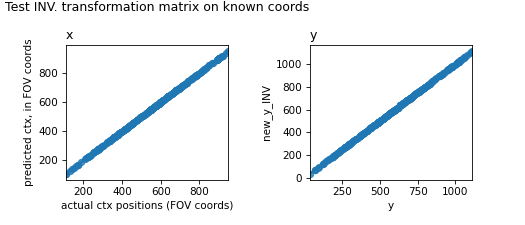

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.01, 0.95, 'Test INV. transformation matrix on known coords')

In [720]:
# transformed2_inv = [T2_I.dot(i) for i in transformed2]
# new_y_inv = np.array([p[1] for p in transformed2_inv])

fig, axn = pl.subplots(1,2, figsize=(7,3))
ax=axn[0]
sns.regplot('x', 'new_x_INV', data=retinodf, ax=ax)
ax.set_ylabel('predicted ctx, in FOV coords')
ax.set_xlabel('actual ctx positions (FOV coords)')
ax.set_title('x', loc='left')

ax=axn[1]
sns.regplot('y', 'new_y_INV', data=retinodf, ax=ax)
ax.set_title('y', loc='left')

pl.subplots_adjust(bottom=0.2, wspace=0.5, top=0.8)

fig.text(0.01, 0.95, 'Test INV. transformation matrix on known coords', fontsize=12)

#### Calculate predicted CTX position from actual RETINO position

In [545]:
# predicted_rf_locs = slope*proj_locs + intercept
# predicted_ctx_locs = (actual_rf_locs - intercept) / slope
def predict_cortex_position(regr, cond='az', points=None):
    g_intercept = float(regr[regr.cond==cond]['intercept'])
    g_slope = float(regr[regr.cond==cond]['coefficient'])
    predicted_ctx_x = (points - g_intercept) / g_slope

    return predicted_ctx_x

# import analyze2p.retinotopy.gradient_estimation as grad

In [546]:
# retinodf['ap_proj'] = ''
proj_results = 'projections'
fpaths = [f for f in glob.glob(os.path.join(rootdir, animalid, 
            session_2p, 'FOV%i_*' % fovnum, retinorun_2p, 
            'retino_analysis/retino_structure', 
            '%s_*.pkl' % (proj_results))) if '_pixels_thr' not in f] 
for fp in fpaths:
    print(fp)

/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/retino_run1/retino_analysis/retino_structure/projections_V1.pkl


In [547]:
fpath = fpaths[0]
with open(fpath, 'rb') as f:
    presults = pkl.load(f, encoding='latin1')
regr = presults['regr_df'].copy()
print(regr.to_markdown())

|    |       R2 |    RMSE |   coefficient | cond   |   intercept |   pearson_p |   pearson_r |
|---:|---------:|--------:|--------------:|:-------|------------:|------------:|------------:|
|  0 | 0.886529 | 1.78109 |    0.0178011  | az     |     19.8711 |           0 |    0.941557 |
|  1 | 0.810955 | 1.46739 |    0.00932511 | el     |    -10.7693 |           0 |    0.90053  |


# Predict CTX pos from retino pos

In [548]:
dst_dir = os.path.join(aggregate_dir, 'retinotopy', 'final_figures')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    

In [555]:
# Predict CTX position based on retino position
# ---------------------------------------------------------------
retino_method='MOVINGBAR' #'RF'
# ---------------------------------------------------------------
if retino_method=='MOVINGBAR':
    DF = retinodf.loc[pass_mag_rois].copy()
    xpos_label = 'az_lin_centered'
    ypos_label = 'el_lin_centered'
else:
    DF = rfdf.copy()
    xpos_label = 'x0'
    ypos_label = 'y0'

p_x = predict_cortex_position(regr, cond='az', 
                          points=DF[xpos_label].values)
p_y = predict_cortex_position(regr, cond='el', 
                          points=DF[ypos_label].values)
DF['predicted_ctx_x'] = p_x
DF['predicted_ctx_y'] = p_y


In [556]:
%matplotlib notebook

<IPython.core.display.Javascript object>


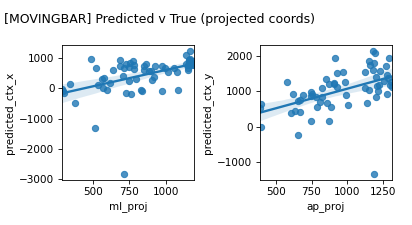

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.01, 0.9, '[MOVINGBAR] Predicted v True (projected coords)')

In [557]:
fig, axn = pl.subplots(1,2, figsize=(5.5,3))
ax=axn[0]
sns.regplot('ml_proj', 'predicted_ctx_x', data=DF, ax=ax)
ax=axn[1]
sns.regplot('ap_proj', 'predicted_ctx_y', data=DF, ax=ax)
pl.subplots_adjust(bottom=0.2, wspace=0.5, left=0.15, right=0.95, top=0.8)
fig.text(0.01, 0.9, '[%s] Predicted v True (projected coords)' % retino_method,
        fontsize=12)

In [558]:
# Transform predicted-ctx pos back to FOV coords
u1 = (gvectors['az'])
u2 = (gvectors['el'])
# Cartesian normal (plus error)
o1 = np.array([1, 0]) + np.finfo(np.float32).eps
o2 = np.array([0, 1]) + np.finfo(np.float32).eps
print(o1, o2)

# X-axis
T1 = roiutils.get_transformation_matrix(u1, o2)
T1_I = np.linalg.inv(T1)
transformed_inv1 = [T1_I.dot(np.array([x, y])) for (x,y) \
                    in DF[['predicted_ctx_x', 'predicted_ctx_y']].values]
invproj_ctx_x = np.array([p[0] for p in transformed_inv1])
# Y-axis
T2 = roiutils.get_transformation_matrix(o1, u2)
T2_I = np.linalg.inv(T2)
transformed_inv2 = [T2_I.dot(np.array([x, y])) for (x,y) \
                    in DF[['predicted_ctx_x', 'predicted_ctx_y']].values]
invproj_ctx_y = np.array([p[1] for p in transformed_inv2])

DF['predicted_ml_pos'] = invproj_ctx_x
DF['predicted_ap_pos'] = invproj_ctx_y


[1.00000012e+00 1.19209290e-07] [1.19209290e-07 1.00000012e+00]


<IPython.core.display.Javascript object>


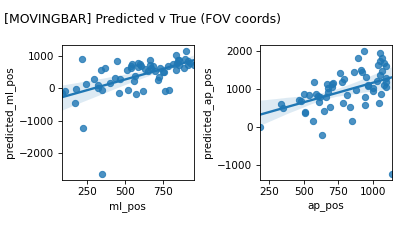

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.01, 0.9, '[MOVINGBAR] Predicted v True (FOV coords)')

In [559]:
fig, axn = pl.subplots(1,2, figsize=(5.5,3))
ax=axn[0]
sns.regplot('ml_pos', 'predicted_ml_pos', data=DF, ax=ax)
ax=axn[1]
sns.regplot('ap_pos', 'predicted_ap_pos', data=DF, ax=ax)
pl.subplots_adjust(bottom=0.2, wspace=0.5, left=0.15, right=0.95, top=0.8)
fig.text(0.01, 0.9, '[%s] Predicted v True (FOV coords)' % retino_method,
        fontsize=12)

#### do it

(31, 16)


<IPython.core.display.Javascript object>


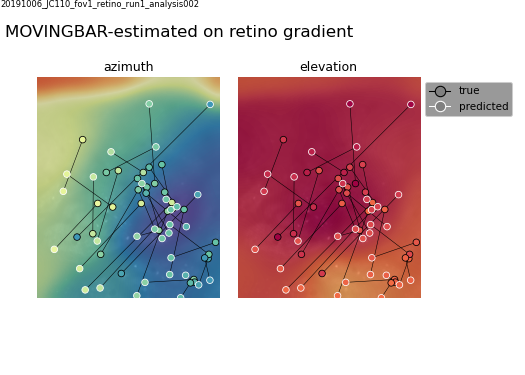

/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/final_figures scattered_retinopos_overlay_MOVINGBAR__20191006_JC110_fov1


In [560]:
# Choose retino pos estimation method
df_ = DF.copy()
xpos_label = 'ml_pos'
ypos_label = 'ap_pos'
retino_x = 'az_lin_centered' if retino_method=='MOVINGBAR' else 'x0'
retino_y = 'el_lin_centered' if retino_method=='MOVINGBAR' else 'y0'

# Make sure we are in bounds
max_ypos, max_xpos = az_map_ctr.shape
plotdf = df_[(df_['predicted_ml_pos']>=0) & (df_['predicted_ml_pos']<=max_xpos)
           & (df_['predicted_ap_pos']>=0) & (df_['predicted_ap_pos']<=max_ypos)].copy()
print(plotdf.shape)
# colors
vmin = min([az_map_ctr.min(), el_map_ctr.min()])
vmax = max([az_map_ctr.max(), el_map_ctr.max()])
normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# markers
np_alpha=0.8
lw=0.75
markersize=40
plot_circles=True # Plot additional circles for PREDICTION
plot_lines=True

fig, axn = pl.subplots(1, 2, figsize=(7,5))
ax = axn[0]

for ax, cond in zip(axn.flat, ['azimuth', 'elevation']):
    ax.set_title(cond)
    ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
    neuropil_map = az_map_ctr if cond=='azimuth' else el_map_ctr
    soma_name = retino_x if cond=='azimuth' else retino_y
    # Plot NP background
    ax.imshow(neuropil_map, cmap=cmap, vmin=vmin, vmax=vmax, alpha=np_alpha)
    # Plot soma
    sns.scatterplot(x=xpos_label, y=ypos_label, data=plotdf, ax=ax,
                alpha=1, hue=soma_name, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor='k', zorder=1000) 
    if plot_circles:
        # Plot predicted positions
        sns.scatterplot(x='predicted_ml_pos', y='predicted_ap_pos', 
                data=plotdf, ax=ax,
                alpha=1, hue=soma_name, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor='w',zorder=1000) 
    if plot_lines:
        # Plot connecting line
        for (x1, y1), (x2, y2) in zip(\
                plotdf[['predicted_ml_pos', 'predicted_ap_pos']].values,
                plotdf[[xpos_label, ypos_label]].values):
            ax.plot([x1, x2], [y1, y2], lw=0.5, markersize=0, color='k')
            
    ax.legend_.remove()

# Custom legend
leg_handles = [mpl.lines.Line2D([0], [0], marker='o', color='k', label='true',
                markerfacecolor='gray', markersize=10, lw=1),
               mpl.lines.Line2D([0], [0], marker='o', color='w', label='predicted',
                markerfacecolor='gray', markersize=10, lw=1)]
ax.legend(handles=leg_handles, loc='upper left', bbox_to_anchor=(1,1),
         facecolor='gray')
for ax in axn.flat:
    ax.axis('off')

pl.subplots_adjust(left=0.07, right=0.8, bottom=0.2, top=0.8, wspace=0.1)
fig.text(0.01, 0.9, '%s-estimated on retino gradient' % retino_method, 
         fontsize=16)
pplot.label_figure(fig, data_id)

figname = 'scattered_retinopos_overlay_%s__%s' % (retino_method, datakey)
pl.savefig(os.path.join(animal_dst_dir, '%s.svg' % figname)) 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname)) 
print(dst_dir, figname)


In [380]:
%matplotlib notebook

<IPython.core.display.Javascript object>


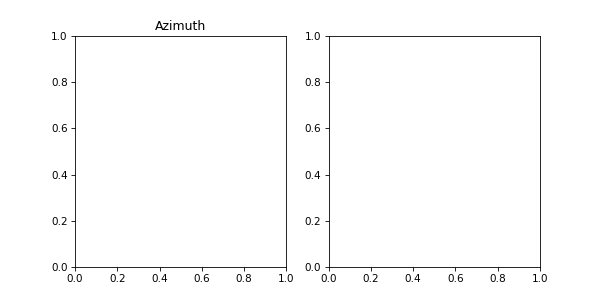

NameError: name 'surface_hd' is not defined

In [381]:
fig, axn = pl.subplots(1,2, figsize=(8,4))
ax=axn[0]
ax.set_title('Azimuth')
ax.imshow(surface_hd, cmap='gray')
im = ax.imshow(az_wf, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.75)
#pl.colorbar(im, orientation='horizontal', shrink=0.8)

ax=axn[1]
ax.set_title('Elevation')
ax.imshow(surface_hd, cmap='gray')
im1 = ax.imshow(el_wf, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.75)

cb = fig.add_axes([0.35, 0.1, 0.2, 0.05])
pl.colorbar(im, cax=cb, orientation='horizontal')

screen_lim_pos = screen_h_max/lmax_alt #(lmax_alt-screen_h_max)/(lmax_alt*2.)
if lmin_az_2p<0: # Center is 0
    cb.axvline(x=screen_lim_pos*lmax_alt, color='w') # my data is between 0 and 1
    cb.axvline(x=screen_lim_pos*lmin_alt, color='w') # my data is between 0 and 1
else: # min=0, max=120
    c_min, c_max = cb.get_xlim()
    cb.axvline(x=c_min+(screen_lim_pos*lmax_alt)/2., color='w') # my data is between 0 and 1
    cb.axvline(x=c_max-(screen_lim_pos*lmax_alt)/2., color='w') # my data is between 0 and 1
#cb.axvline(x=0, color='w')

In [100]:
aggregate_results_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/caiman_examples'

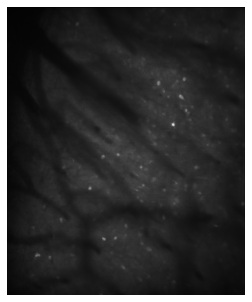

In [101]:

fig = pl.figure(figsize=(5,4), frameon=False)
ax = pl.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(zimg_r, cmap='gray') #, 

figname = '2pfov'
pl.savefig(os.path.join(aggregate_results_dir, '%s_%s_%s.png' \
                        % ( figname, animalid, session_2p)))

# Plot example traces 

In [102]:
animal_dst_dir

'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_7e9e1a/visualization'

In [68]:
curr_dst_dir = os.path.join(animal_dst_dir, 'example_traces')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_670ea2/visualization/example_traces


In [69]:
def plot_example_traces(soma_traces, np_traces, rid=0, cond='right',
                       soma_color='k', np_color='r', ax=None):
    
    if ax is None:
        fig, ax = pl.subplots()
    ax.plot(soma_traces[cond][rid], soma_color, label='soma')
    ax.plot(np_traces[cond][rid], np_color, label='neuropil')
    
    return ax

In [70]:
animalid, session, fov, retinorun_2p

('JC084', '20190517', 'FOV1_zoom2p0x', 'retino_run1')

In [71]:
# soma_traces = rutils.load_traces(animalid, session, fov, run=retinorun,
#                                   analysisid=retinoid, trace_type='raw')

soma_traces = load_roi_traces(animalid, session_2p, fov, run=retinorun_2p,
                 analysisid=retinoid, trace_type='corrected', detrend_after_average=True)

# Do fft

... loading traces (corrected)
... loading traces from: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_670ea2


In [72]:
### Convert raw/processed traces to df/f
dff_soma = dict((cond, (tdf - tdf.mean(axis=0))/ tdf.mean(axis=0)) for cond, tdf in soma_traces.items())
#dff_np = dict((cond, (tdf - tdf.mean(axis=0))/ tdf.mean(axis=0)) for cond, tdf in np_traces.items())


In [73]:
# Get average across conditions
mean_phase_values_soma = phases_soma.mean(axis=1).values 

mean_magratio_values_soma = magratios_soma.mean(axis=1).values 
mean_magratio_values_np = magratios_np.mean(axis=1).values

# Sort ROIs by their average mag ratios
sorted_rois_soma = np.argsort(mean_magratio_values_soma)[::-1]
for roi in sorted_rois_soma[0:10]:
    print(roi, mean_magratio_values_soma[roi].round(3), mean_phase_values_soma[roi].round(3))

155 0.038 -0.161
48 0.034 -1.112
222 0.029 2.039
75 0.029 -0.744
67 0.029 0.729
17 0.028 2.454
89 0.027 -0.981
178 0.027 -0.534
14 0.027 1.946
141 0.026 -1.062


In [74]:
cycle_start_ixs = scaninfo['stimulus']['cycle_start_ixs']

In [76]:
    #n_cycles = int(round((n_frames/fr) / stimperiod))
    #n_frames_per_cycle = int(np.floor(stimperiod * fr))
    #cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')

    n_frames = scaninfo['stimulus']['n_frames']
    fr = scaninfo['stimulus']['frame_rate']
    stimfreq= scaninfo['stimulus']['stim_freq']
    
    # Get frequency info
    freqs = np.fft.fftfreq(n_frames, float(1./fr))
    sorted_idxs = np.argsort(freqs)
    freqs = freqs[sorted_idxs] # sorted
    freqs = freqs[int(np.round(n_frames/2.))+1:] # exclude DC offset from data
    stim_freq_idx = np.argmin(np.absolute(freqs - stimfreq)) # Index of stimulation frequency

# get phase and magnitude
#     mag_data = abs(fft_results)
#     phase_data = np.angle(fft_results)

#     # sort mag and phase by freq idx:
#     mag_data = mag_data[sorted_idxs]
#     phase_data = phase_data[sorted_idxs]

In [77]:
dff_soma['right']

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,-0.133299,-0.010842,0.095980,0.322191,-0.024589,-0.054382,0.017868,-0.028247,-0.041393,0.042884,...,0.005675,-0.067252,0.000216,0.055244,-0.015129,-0.036244,-0.007701,0.019082,0.023167,0.044385
1,0.108996,0.035121,-0.037225,0.325913,-0.026256,-0.076572,-0.020247,0.001896,-0.011939,0.031696,...,-0.023762,-0.015434,0.005613,0.021468,-0.038165,-0.013654,-0.016632,0.049906,-0.021121,-0.017154
2,0.194340,0.018926,-0.096685,0.190209,0.013481,-0.092475,-0.017136,-0.024296,0.043793,0.008681,...,-0.019512,0.067898,-0.010958,-0.044837,-0.040472,0.024642,0.006852,0.077150,-0.055891,-0.068325
3,0.043831,-0.032363,0.050300,0.084376,-0.022552,0.004346,0.053890,0.061606,0.099547,0.040751,...,-0.016545,0.072189,0.008538,-0.072148,-0.025532,0.045243,0.040904,0.042730,-0.029556,-0.013771
4,0.035061,-0.021895,0.081915,0.144443,-0.043644,-0.004896,-0.005284,0.170472,0.093780,0.067156,...,-0.006805,0.057831,0.017967,-0.084556,-0.038163,0.033646,0.042580,0.049660,0.005500,0.009264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4117,-0.081527,-0.059718,-0.024751,-0.001117,0.034554,-0.073539,0.034886,0.051806,-0.046967,-0.066246,...,-0.074799,-0.038181,0.069215,-0.020528,0.054060,0.004450,0.044244,0.025329,-0.014265,-0.026577
4118,-0.096042,-0.020511,-0.092174,0.050723,0.010028,-0.086733,-0.007218,0.022932,-0.020361,-0.030579,...,-0.084228,-0.081068,0.069732,-0.002851,0.033485,-0.048464,-0.009190,0.032399,-0.019076,-0.047180
4119,-0.067446,-0.038417,-0.089866,0.034893,0.049872,-0.050555,0.041610,0.017520,-0.022605,-0.036067,...,-0.023329,-0.071806,0.072445,-0.001122,0.020171,-0.018125,-0.021919,-0.002395,0.027268,-0.086800
4120,-0.029151,-0.034180,-0.050310,0.055923,0.069372,-0.089503,0.054279,0.073688,-0.070694,-0.044822,...,-0.033194,-0.004084,0.053728,-0.013795,0.032481,-0.000272,-0.005577,0.017059,0.087236,-0.073242


In [78]:

def do_fft_return_arrray(avg_traces, sorted_idxs, stim_freq_idx):
    n_frames = avg_traces.shape[0]

    fft_results = np.fft.fft(avg_traces, axis=0) #avg_traces.apply(np.fft.fft, axis=1)

    # get phase and magnitude
    mag_data = abs(fft_results) #**2
    phase_data = np.angle(fft_results)

    # sort mag and phase by freq idx:
    mag_data = mag_data[sorted_idxs]
    phase_data = phase_data[sorted_idxs]

    # exclude DC offset from data
    #if len(mag_data.shape)==1:
    print("excl offset")
    mag_data = mag_data[int(np.round(n_frames/2.))+1:]
    phase_data = phase_data[int(np.round(n_frames/2.))+1:]
    
    return pd.DataFrame(mag_data), pd.DataFrame(phase_data)

In [79]:
marray, parray = do_fft_return_arrray(dff_soma['right'], sorted_idxs, stim_freq_idx)


excl offset


<IPython.core.display.Javascript object>


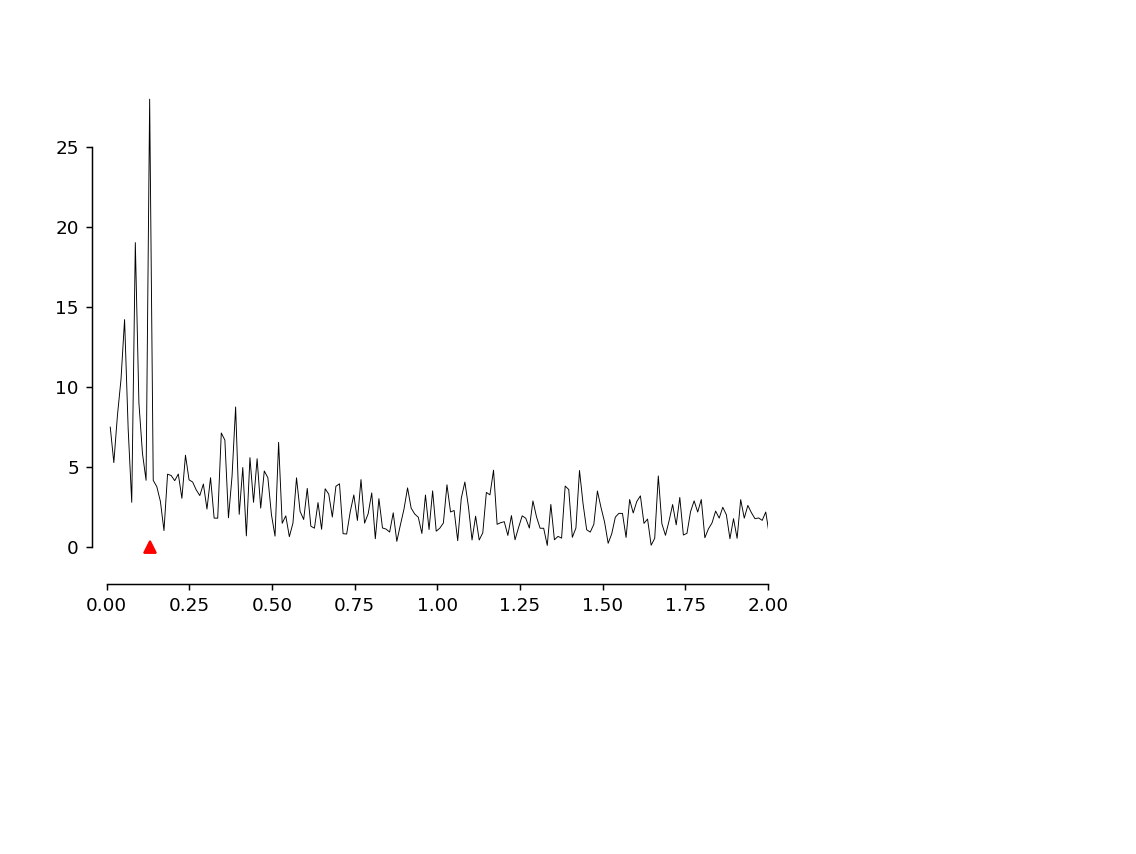

0.12999359534206695 0.12999359534206695


In [81]:
rid = 155
fig, ax = pl.subplots()

max_idx = marray[rid].argmax()
print(freqs[max_idx], freqs[stim_freq_idx])
label='Cell %i, max=%.2f Hz' % (rid, freqs[max_idx])
ax.plot(freqs, marray[rid], color='k', lw=0.5, label=label)
ax.plot(freqs[stim_freq_idx], 0, 'r^')
ax.set_xlim([0, 2])
sns.despine(trim=True, offset=8)

In [82]:
np.array(scaninfo['frame_nums']).astype(float)


array([1.000e+00, 2.000e+00, 3.000e+00, ..., 4.120e+03, 4.121e+03,
       4.122e+03])

In [79]:
import matplotlib.gridspec as gridspec
# Plotting
def label_figure(fig, data_identifier):
    fig.text(0, 1,data_identifier, ha='left', va='top', fontsize=8)

    

In [80]:
sorted_rois_soma[0:5]

NameError: name 'sorted_rois_soma' is not defined

<IPython.core.display.Javascript object>


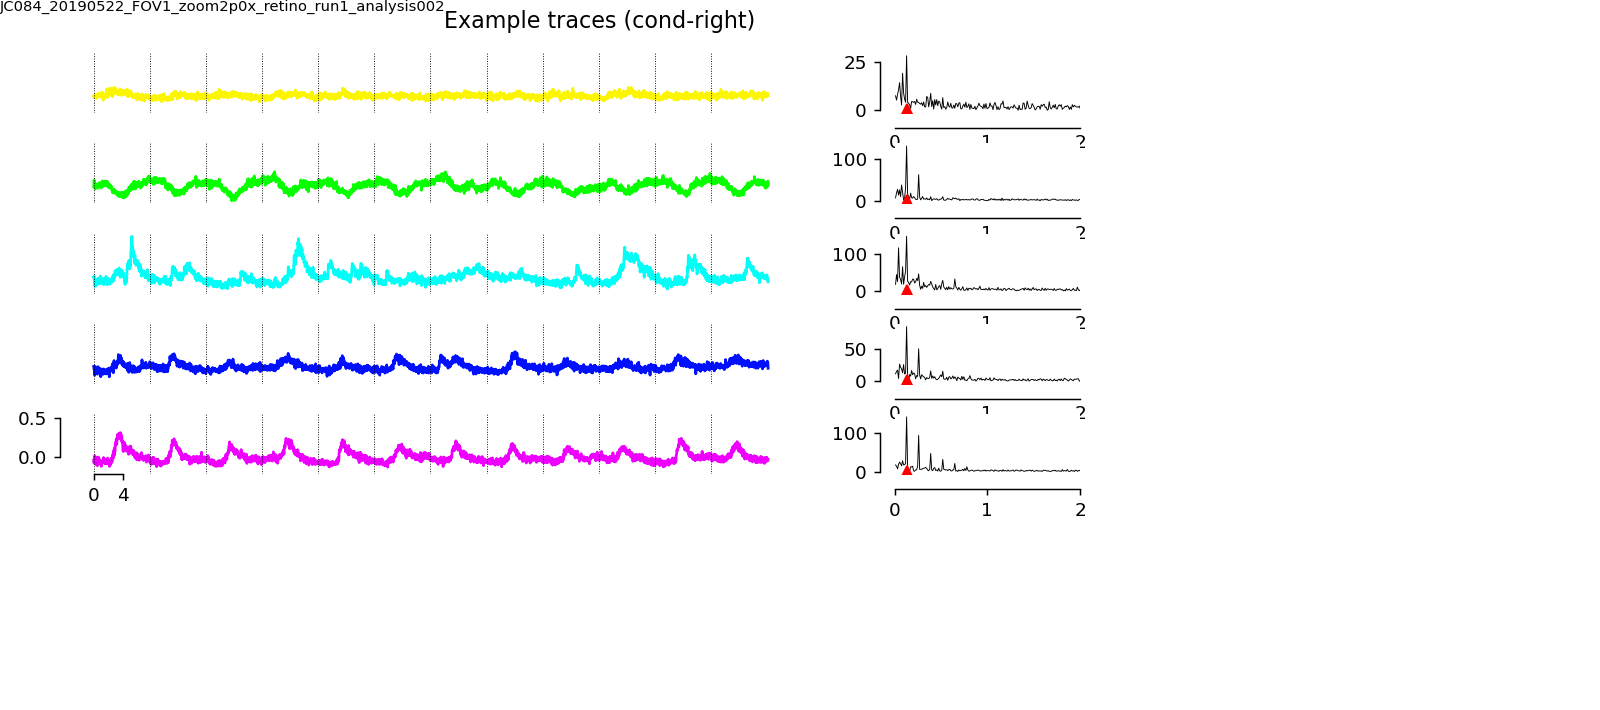

[]
[<AxesSubplot:>, <AxesSubplot:>]
[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]
[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]
[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]


In [85]:
#plot_rois = [57, 355, 247] #, 346] #, id = sorted_rois_soma[0] #113
plot_rois = sorted_rois_soma[0:5]

roi_colors = sns.color_palette(cmap, n_colors=len(plot_rois))
save_plot = True

cond='right'
time_sec = np.array(scaninfo['frame_nums']).astype(float) * (1./fr)
#fig, axn = pl.subplots(4, 1, sharex=True, sharey=True, figsize=(5, 6))

fig = pl.figure(figsize=(9,4))
gs = gridspec.GridSpec(len(plot_rois), 4) # sharex=True, sharey=True)


for ai, (col, rid) in enumerate(zip( roi_colors, plot_rois)):
    print(fig.axes)
    if ai==0:
        ax=fig.add_subplot(gs[ai, 0:3])
    else:
        ax=fig.add_subplot(gs[ai, 0:3], sharex=fig.axes[0], sharey=fig.axes[0])
    ax.plot(time_sec, dff_soma[cond][rid], color=col, label='soma')
    for cyc in cycle_start_ixs:
        ax.axvline(x=time_sec[cyc], linestyle=':', linewidth=0.5, color='k')
    if ai!=(len(plot_rois)-1):
        ax.axis('off')
    else:
        ax.set_xticks([0, 4])

    if ai==0:
        ax=fig.add_subplot(gs[ai, 3:])
    else:
        ax=fig.add_subplot(gs[ai, 3:], sharex=fig.axes[1]) #, sharey=fig.axes[1])
    max_idx = marray[rid].argmax()
    #print(freqs[max_idx], freqs[stim_freq_idx])
    label='Cell %i, max=%.2f Hz' % (rid, freqs[max_idx])
    ax.plot(freqs, marray[rid], color='k', lw=0.5, label=label)
    ax.plot(freqs[stim_freq_idx], 0, 'r^')
    ax.set_xlim([0, 2])
    sns.despine(trim=True, offset=8, ax=ax)
    if ai!=(len(plot_rois)-1):
        ax.tick_params(which='both', axis='x', size=0) #off')
        #ax.set_xticks([])

    
pl.subplots_adjust(left=0.05, right=0.9, hspace=0.5, top=0.9, wspace=0.5)
sns.despine(trim=True)

pl.suptitle('Example traces (cond-%s)' % cond)
label_figure(fig, data_id)


pl.savefig(os.path.join(curr_dst_dir, 'dff_traces_with_magspec.svg'))

In [247]:
time_sec

50.008062204385844

# CaImAn extracted traces

In [93]:
import pickle as pkl

In [94]:
roi_retino_file = '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/retino_analysis/retino_analysis.pkl'

with open(roi_retino_file, 'rb') as f:
    roiret = pkl.load(f)
roiret.keys()

dict_keys(['azi_np', 'el_np', 'retinodf'])

In [95]:
azi_2p_np = roiret['azi_np']
el_2p_np = roiret['el_np']


In [777]:
caiman_results_dir = '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/caiman_results'
caiman_retino_file = os.path.join(caiman_results_dir, 'retino_analysis.pkl')

with open(caiman_retino_file, 'rb') as f:
    caiman = pkl.load(f)
caiman.keys()

dict_keys(['traces', 'dff_traces', 'magratios', 'phases', 'masks'])

In [721]:
caiman['masks'].shape
masks_cm = caiman['masks'].copy()
magratios_cm = caiman['magratios'].copy()
phases_cm = caiman['phases'].copy()

<IPython.core.display.Javascript object>


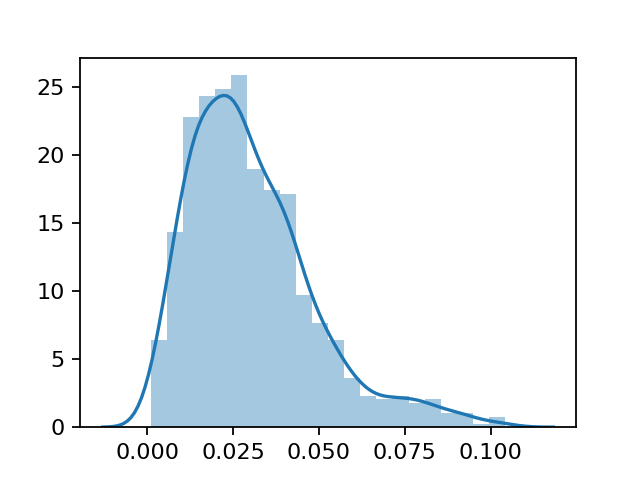

<AxesSubplot:>

In [722]:
pl.figure(figsize=(4,3))
sns.distplot(magratios_cm.values.ravel())

In [725]:
print(lmin_az_2p,lmax_az_2p)

0 119.5564


In [726]:
magratios_cm.head()

,top,right,left,bottom
0,0.018599,0.044401,0.057904,0.043133
1,0.011950,0.048199,0.053802,0.005852
2,0.023249,0.021369,0.032923,0.039585
3,0.022103,0.023061,0.021712,0.025529
4,0.013062,0.019189,0.017699,0.005421


In [727]:
phases_soma.max()

top       3.097671
bottom    3.141589
left      3.075773
right     3.138163
dtype: float64

In [728]:
df_cm.head()

,phase_az,phase_el,mag_az,mag_el,az_lin,el_lin
0,1.443499,-0.110782,0.051153,0.030866,87.245094,57.670235
1,2.076685,-1.201524,0.051001,0.008901,99.293355,36.915603
2,NaN,NaN,0.027146,0.031417,NaN,NaN
3,NaN,NaN,0.022386,0.023816,NaN,NaN
4,-0.434587,-0.754272,0.018444,0.009242,51.508887,45.425919


In [729]:
# Combine conds to get absolute maps
trials_by_cond=None
use_pixels=False
ds_factor=2
abs_vmin = -np.pi
abs_vmax=np.pi

# d1_orig=512
# d2_orig=512
magthr_2p = 0.01
delay_map_thr=1.5
df_cm = get_final_maps(magratios_cm, phases_cm, trials_by_cond=None,
                    mag_thr=magthr_2p, dims=(d1_orig, d2_orig), 
                       ds_factor=ds_factor, use_pixels=use_pixels)
print(df_cm.shape)

df_cm['az_lin'] = convert_range(df_cm['phase_az'], newmin=lmin_az_2p, newmax=lmax_az_2p, 
                                   oldmin=abs_vmin, oldmax=abs_vmax)

df_cm['el_lin'] = convert_range(df_cm['phase_el'], newmin=lmin_az_2p, newmax=lmax_az_2p, 
                                   oldmin=abs_vmin, oldmax=abs_vmax)

got phase: 0.0031100160907883154 6.2676568461620406
got absolute: -2.89395610524568 3.06223009063191
Delay: 0.25837490556725107 6.192169297158616
Total: 208
 After mag_thr (0.010): 208
 After delay_thr (1.500): 151
(208, 4)


In [730]:
# Get pixel size
ncomp, d1_cm, d2_cm = masks_cm.shape

ds_cm = d1_orig/float(d1_cm)
pixel_size = get_pixel_size()
pixel_size_ds = (pixel_size[0]*ds_cm, pixel_size[1]*ds_cm)
d1_cm = int(d1_cm/ds_cm)
d2_cm = int(d2_cm/ds_cm)
print(d1_cm, d2_cm)

512 512


In [731]:
pixel_size_ds

(2.3, 1.9)

In [732]:
# Reshape and transform maps for visualization
nrois_total = masks_cm.shape[0]
masks_r0 = np.dstack([transform_2p_fov(masks_cm[i, :], pixel_size_ds, normalize=False) \
                     for i in range(nrois_total)]).T
masks_r_cm = np.swapaxes(masks_r0, 1, 2) # [nrois, d1/rows/y, d2/cols]
print(masks_r_cm.shape)

(208, 1177, 972)


<IPython.core.display.Javascript object>


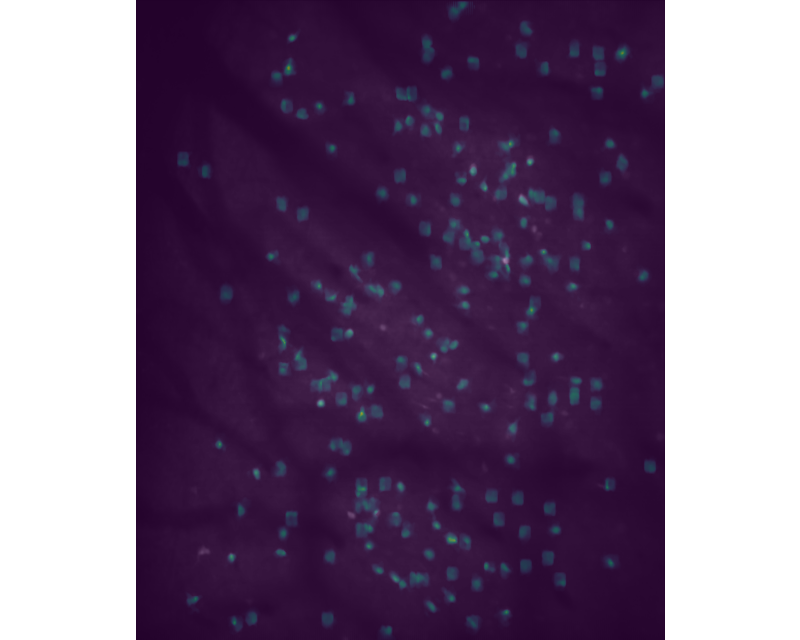

In [733]:

fig = pl.figure(figsize=(5,4), frameon=False)
ax = pl.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

ax.imshow(zimg_r, cmap='gray')
ax.imshow(masks_r_cm.sum(axis=0), alpha=0.5)

# fig = pl.figure(figsize=(5,4), frameon=False)
# ax = pl.Axes(fig, [0., 0., 1., 1.])
# ax.set_axis_off()
# fig.add_axes(ax)
# im = ax.imshow(surface_hd, cmap='gray', interpolation='nearest')


In [734]:
magratios_cm

,top,right,left,bottom
0,0.018599,0.044401,0.057904,0.043133
1,0.011950,0.048199,0.053802,0.005852
2,0.023249,0.021369,0.032923,0.039585
3,0.022103,0.023061,0.021712,0.025529
4,0.013062,0.019189,0.017699,0.005421
...,...,...,...,...
203,0.018811,0.012095,0.008399,0.026636
204,0.015698,0.046346,0.011570,0.002312
205,0.028132,0.043734,0.029000,0.021221
206,0.053847,0.083426,0.079973,0.087089


In [756]:
# Get centroids of ROI masks for visualization
centroids_cm = get_roi_centroids(masks_r_cm)
retinodf_cm = pd.concat([centroids_cm, df_cm], axis=1)
retinodf_cm.head()

,x,y,phase_az,phase_el,mag_az,mag_el,az_lin,el_lin
0,855.0,946.0,1.443499,-0.110782,0.051153,0.030866,87.245094,57.670235
1,155.0,956.0,2.076685,-1.201524,0.051001,0.008901,99.293355,36.915603
2,301.0,893.0,NaN,NaN,0.027146,0.031417,NaN,NaN
3,106.0,890.0,NaN,NaN,0.022386,0.023816,NaN,NaN
4,93.0,896.0,-0.434587,-0.754272,0.018444,0.009242,51.508887,45.425919


In [757]:
# import sys
# !{sys.executable} -m pip install jupyterthemes

In [758]:
retinodf_cm.shape, retinodf_cm[retinodf_cm.mag_az>=magthr_2p].shape

((208, 8), (92, 8))

In [759]:
magthr_2p=0.03

pass_rois_cm = retinodf_cm[retinodf_cm.mag_az>=magthr_2p].dropna().index.tolist()
print("%i of %i cells pass mag thr (%.2f)" % (len(pass_rois_cm), len(retinodf_cm), magthr_2p))

76 of 208 cells pass mag thr (0.03)


In [760]:
curr_vmin = np.min([retinodf_cm.loc[pass_rois_cm][['az_lin', 'el_lin']].min()])
curr_vmax = np.max([retinodf_cm.loc[pass_rois_cm][['az_lin', 'el_lin']].max()])
print(curr_vmin, curr_vmax)

14.715649970493248 111.86210196208395


In [761]:

colormap = 'batlow' #'nic_Edge'
cmapdir = '/n/coxfs01/julianarhee/colormaps' #os.path.join(aggr_dir, 'colormaps')
cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
cmap_phase = LinearSegmentedColormap.from_list('my_colormap', cdata[::-1])


<IPython.core.display.Javascript object>


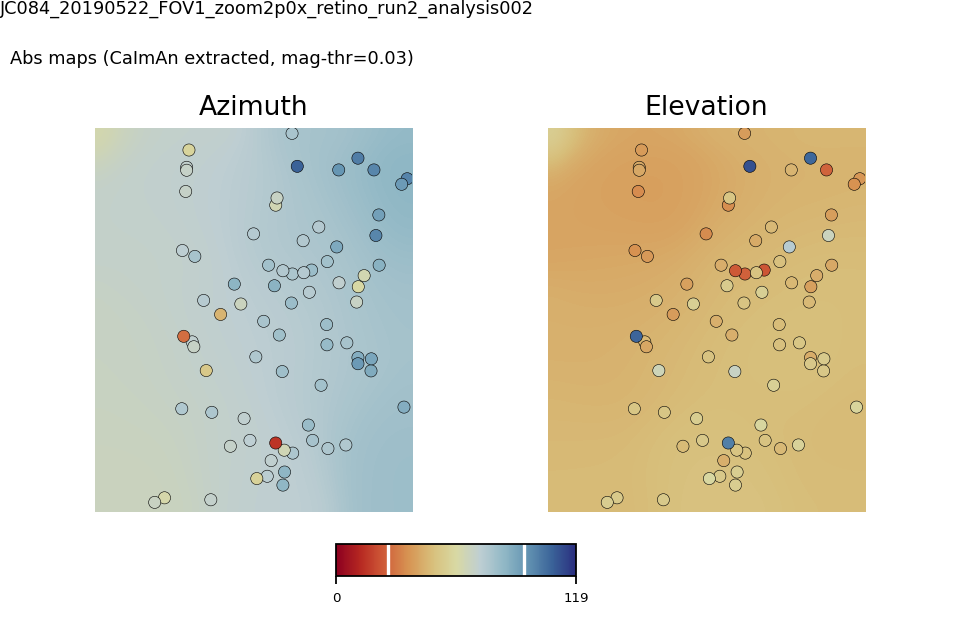

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/caiman_results smoothed_np_retino_with_centroids_LIN


In [852]:
# vmin = curr_vmin#lmin_az_2p
# vmax = curr_vmax #lmax_az_2p
vmin = lmin_az_2p
vmax = lmax_az_2p
cmap=dark_spectral#'RdYlBu' #cmap_phase #'Spectral'#'twilight' #pl.get_cmap('cmr.guppy')
lw=0.25
alpha=1
markersize=30

normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

fig, axn = pl.subplots(1, 2, figsize=(6,4))
ax = axn[0]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
ax.imshow(azi_2p_np, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
sns.scatterplot(x='y', y='x', data=retinodf_cm.loc[pass_rois_cm], 
                hue='az_lin', ax=ax, palette=cmap, alpha=1, hue_norm=normalize,
                linewidth=lw, edgecolor='k', s=markersize)
ax.set_title("Azimuth")
ax.legend_.remove()

ax = axn[1]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
im = ax.imshow(el_2p_np, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
sns.scatterplot(x='y', y='x', data=retinodf_cm.loc[pass_rois_cm], 
                hue='el_lin', ax=ax, palette=cmap, alpha=1, hue_norm=normalize,
                linewidth=lw, edgecolor='k', s=markersize)
ax.set_title("Elevation")
ax.legend_.remove()

pl.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.8, wspace=0.1)
fig.text(0.01, 0.9, 'Abs maps (CaImAn extracted, mag-thr=%.2f)' %magthr_2p, fontsize=8)

cb = fig.add_axes([0.35, 0.1, 0.25, 0.05])
cbar = pl.colorbar(im, cax=cb, orientation='horizontal', ticks=[vmin, vmax])
ab_max_az = max([abs(lmax_az_2p), abs(lmin_az_2p)])
ab_max_el = max([abs(lmin_el_2p), abs(lmax_el_2p)])
screen_lim_pos = ab_max_el/ab_max_az #(lmax_alt-screen_h_max)/(lmax_alt*2.)
if abs(round(lmin_az_2p))==abs(round(lmax_az_2p)):#<0: # Center is 0
    cb.axvline(x=screen_lim_pos*lmax_az_2p, color='w') # my data is between 0 and 1
    cb.axvline(x=screen_lim_pos*lmin_az_2p, color='w') # my data is between 0 and 1
else: # min=0, max=120
    c_min, cmax = cb.get_xlim()
    screen_midp = (ab_max_az/2.)
    cb.axvline(x=screen_midp+(screen_lim_pos*ab_max_az)/2., color='w') # my data is between 0 and 1
    cb.axvline(x=screen_midp-(screen_lim_pos*ab_max_az)/2., color='w') # my data is between 0 and 1
# cbar.ax.set_xticklabels([int(curr_vmax), int(curr_vmin)], fontsize=6)
cbar.ax.set_xticklabels([int(lmin_az_2p), int(lmax_az_2p)], fontsize=6)

for ax in axn.flat:
    ax.axis('off')

label_figure(fig, data_id)
figname = 'smoothed_np_retino_with_centroids_LIN'
pl.savefig(os.path.join(caiman_results_dir, '%s.pdf' % figname)) 

print(caiman_results_dir, figname)

pl.savefig(os.path.join(aggregate_results_dir, '%s_%s_%s.pdf' \
                        % (figname, animalid, session_2p)))

In [763]:
cbar.ax.get_xlim()

(0.0, 119.5564)

## Plot traces

In [743]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap as lsc

def cmap_map(function, cmap, name='colormap_mod', N=None, gamma=None):
    """
    Modify a colormap using `function` which must operate on 3-element
    arrays of [r, g, b] values.

    You may specify the number of colors, `N`, and the opacity, `gamma`,
    value of the returned colormap. These values default to the ones in
    the input `cmap`.

    You may also specify a `name` for the colormap, so that it can be
    loaded using pl.get_cmap(name).
    """
    if N is None:
        N = cmap.N
    if gamma is None:
        gamma = cmap._gamma
    cdict = cmap._segmentdata
#     # Cast the steps into lists:
#     step_dict = {key: map(lambda x: x[0], cdict[key]) for key in cdict}
#     print(step_dict)
#     # Now get the unique steps (first column of the arrays):
#     step_list = np.unique(sum(step_dict.values(), []))
    step_dict = dict((k, list(v)) for k, v in cdict.items())
    step_list = np.unique(sum(step_dict.values(), []))

    # 'y0', 'y1' are as defined in LinearSegmentedColormap docstring:
    y0 = cmap(step_list)[:, :3]
    y1 = y0.copy()[:, :3]
    # Go back to catch the discontinuities, and place them into y0, y1
    for iclr, key in enumerate(['red', 'green', 'blue']):
        for istp, step in enumerate(step_list):
            try:
                ind = step_dict[key].index(step)
            except ValueError:
                # This step is not in this color
                continue
            y0[istp, iclr] = cdict[key][ind][1]
            y1[istp, iclr] = cdict[key][ind][2]
    # Map the colors to their new values:
#     y0 = np.array(map(function, y0))
#     y1 = np.array(map(function, y1))
    y0 = function(y0)
    y1 = function(y1)
    # Build the new colormap (overwriting step_dict):
    for iclr, clr in enumerate(['red', 'green', 'blue']):
        step_dict[clr] = np.vstack((step_list, y0[:, iclr], y1[:, iclr])).T
    return lsc(name, step_dict, N=N, gamma=gamma)

def darken(x, ):
   return x * 0.85

dark_spectral = cmap_map(darken, pl.get_cmap('RdYlBu'))

In [744]:
dark_spectral = cmap_map(darken, pl.get_cmap('RdYlBu'))
cmap = dark_spectral #'Spectral' #dark_spectral

In [745]:
caiman['phases'][curr_cond].min()

-3.1343547812673807

In [764]:
magthr_2p = 0.03
pass_rois_cm = retinodf_cm[retinodf_cm.mag_az>=magthr_2p].dropna().index.tolist()
curr_cond='right'

sorted_by_az_mag = retinodf_cm.loc[pass_rois_cm].sort_values(by='mag_az', ascending=True).index.tolist()
sorted_by_az_lin = retinodf_cm.loc[pass_rois_cm].sort_values(by='az_lin', ascending=True).index.tolist()


In [765]:
phase_array = caiman['phases'][curr_cond].copy()
phase_array_cont =  -1 * phase_array
phase_array_cont = phase_array_cont % (2*np.pi)

sorted_by_cond_mag = phase_array_cont.loc[pass_rois_cm]\
                            .sort_values(ascending=True).index.tolist()

In [766]:
print(phase_array_cont.min(), phase_array_cont.max())
print(phase_array.min(), phase_array.max())
print(curr_cond)

0.039654524653239494 6.250144332772475
-3.1343547812673807 3.1168565181697137
right


In [767]:
cycle_start_ixs = scaninfo['stimulus']['cycle_start_ixs']
cycle_start_ixs

array([   0,  186,  372,  558,  744,  930, 1116, 1302, 1488, 1674, 1860,
       2046])

In [768]:
fr = scaninfo['stimulus']['frame_rate']
cycle_start_secs = [i/fr for i in cycle_start_ixs]

In [769]:
2233/44.65

50.01119820828668

In [784]:
def zscore_dataframe(xdf):
    #rlist = [r for r in xdf.columns if isnumber(r)]
    z_xdf = (xdf-xdf.mean()).divide(xdf.std())
    return z_xdf

In [793]:
dff_traces = zscore_dataframe(pd.DataFrame(caiman['traces'][curr_cond]))


In [833]:
use_denoised=True
zscore=True
if use_denoised:
    if zscore:
        currt = zscore_dataframe(pd.DataFrame(caiman['traces'][curr_cond]))
    else:
        currt = caiman['traces'][curr_cond].copy()
else:
    # zscore
    if zscore: 
        currt= zscore_dataframe(pd.DataFrame(caiman['dff_traces'][curr_cond]))
        

scaled cmap lim: (0.0, 6.283185307179586)


<IPython.core.display.Javascript object>


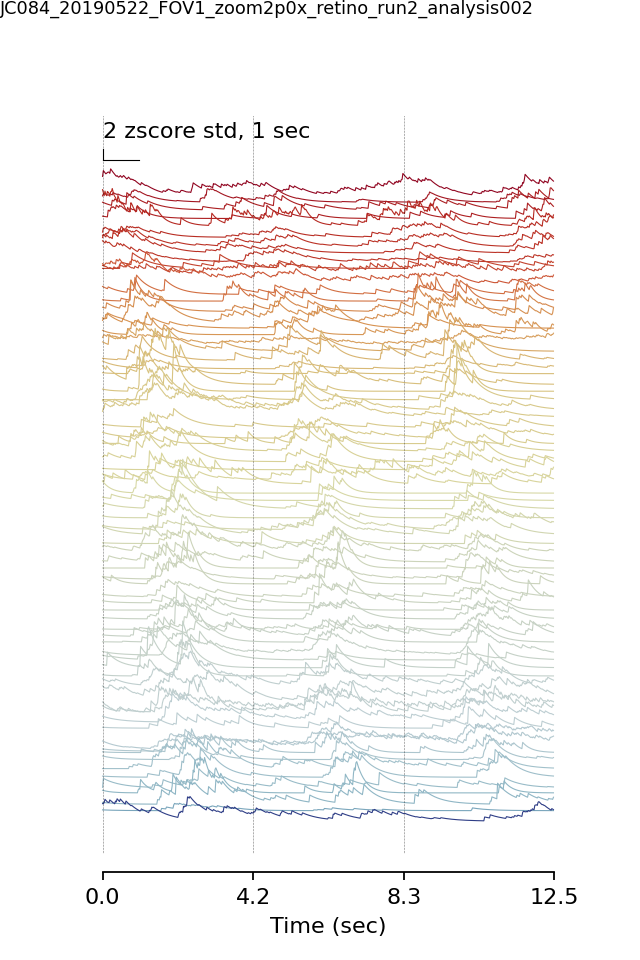

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/caiman_results traces_waterfall_3cyc


In [851]:
n_cycles_plot = 3
n_frames_plot = scaninfo['stimulus']['n_frames_per_cycle']*n_cycles_plot

sorted_list = sorted_by_cond_mag[0::].copy()
offset=-1.5 if zscore else -150*2.
# offset=-0.005
lw=0.5
if zscore:
    yleg_pos=5
    y_scale=2.0
    leg_nsec=1.0
    x_scale=leg_nsec*fr

#hue_values = retinodf_cm.loc[sorted_list]['az_lin']
# vmin = lmin_az_2p#(lmin_az_2p/2.)
# vmax = lmax_az_2p#lmax_az_2p/2.

hue_values = phase_array_cont.loc[sorted_list]
vmin=0#-np.pi
vmax=2*np.pi

vmin = vmin if vmin is not None else hue_values[sorted_list].min()
vmax = vmax if vmax is not None else hue_values[sorted_list].max()

cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
scalarmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap)
print("scaled cmap lim:", scalarmap.get_clim())
    
fig, ax = pl.subplots(figsize=(4,6))
last_y = 0
for ri,rid in enumerate(sorted_list):
    if ri==0:
        #ax.plot([0, 20], [20, 20], 'r')
        ax.plot([0, x_scale], [yleg_pos, yleg_pos], color='k', lw=lw)
        ax.plot([0, 0], [yleg_pos, yleg_pos+y_scale], color='k', lw=lw)
        ax.text(0, yleg_pos+y_scale*2, '2 zscore std, %i sec' % leg_nsec)
    cval = scalarmap.to_rgba(hue_values.loc[rid])
    im = ax.plot(currt[rid].iloc[0:n_frames_plot] + last_y, color=cval, lw=lw, alpha=1)
    #last_y = caiman['traces'][curr_cond][rid].mean() + ri*offset
    last_y += offset
    ax.set_yticks([])
for ci in cycle_start_ixs:
    if ci < n_frames_plot:
        ax.axvline(x=ci, linestyle=':', color='k', linewidth=0.25)
ax.set_xticks(cycle_start_ixs[0:n_cycles_plot+1])
ax.set_xticklabels([round(i, 1) for i in cycle_start_secs[0:n_cycles_plot+1]])

sns.despine(trim=True, offset=8, left=True) 
ax.set_xlabel('Time (sec)')

label_figure(fig, data_id)
figname = 'traces_waterfall_%icyc' % n_cycles_plot
pl.savefig(os.path.join(caiman_results_dir, '%s.pdf' % figname))

print(caiman_results_dir, figname)

pl.savefig(os.path.join(aggregate_results_dir, '%s_%s_%s.pdf' \
                        % (figname, animalid, session_2p)))


In [840]:
aggregate_results_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/caiman_examples'

In [845]:
animalid, session_2p

('JC084', '20190522')

In [444]:
# plt.imshow(ras, cmap=cmap, clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
# plt.colorbar()

In [ ]:

def plot_sorted_traces(avg_traces, sorted_list, hue_values, hue_label='hue', cmap='cool', lw=1,
                       vmin=None, vmax=None, cbar_orientation='vertical', cbar_invert=False, cbar_aspect=False,
                      stimlines=[], ticks_every=0.1, offset=200, figsize=(8, 16), label_rois=False):

    vmin = vmin if vmin is not None else hue_values[sorted_list].min()
    vmax = vmax if vmax is not None else hue_values[sorted_list].max()
    #cnorm = mpl.colors.LogNorm(vmin=vmin,vmax=vmax)
    cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    scalarmap = cmx.ScalarMappable(norm=cnorm, cmap=cmap)
    print("scaled cmap lim:", scalarmap.get_clim())

    fig, ax = pl.subplots(figsize=figsize)
    if transparent:
        fig.patch.set_alpha(0.)
        ax.patch.set_alpha(0.)
        cycle_color = 'w'
    else:
        cycle_color = 'k'
    
    #offset = 200
    last_y = 0
    for ri,rid in enumerate(sorted_list):
        cval = scalarmap.to_rgba(hue_values[rid])
        im = ax.plot(avg_traces[rid] + last_y, color=cval, lw=lw, alpha=0.8)
        last_y = avg_traces[rid].mean() + ri*offset

    for cyc in stimlines:
        ax.axvline(x=cyc, color=cycle_color, linestyle=':', lw=0.75, alpha=1)

    sns.despine(trim=True, offset=8, left=True, bottom=True)
    if label_rois:
        ax.set_yticks([ri*offset + avg_traces[rid].mean() for ri,rid in enumerate(sorted_list)])
        ax.set_yticklabels([rid for rid in sorted_list])
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_xticklabels([])

    pl.subplots_adjust(left=0.01, top=0.9, right=0.85)

    # colorbar
    bounds = np.linspace(vmin, vmax)
    scalarmap.set_array(bounds)
    if cbar_orientation == 'vertical':
        if cbar_aspect:
            cbar_axes = [0.83, 0.17, 0.14, 0.1]
        else:
            cbar_axes = [0.91, 0.17, 0.02, 0.3]
    else:
        cbar_axes = [0.83, 0.17, 0.14, 0.1]
        
    cbar_ax = fig.add_axes(cbar_axes)
    cbar = fig.colorbar(scalarmap, cax=cbar_ax, #boundaries=np.arange(-0.5, ncolors, 1), \
                        ticks=bounds, norm=cnorm, orientation=cbar_orientation) #, format=formatter)
    
    if cbar_orientation == 'vertical':
        ytick_locator = MultipleLocator(ticks_every) #MaxNLocator(min_n_ticks=20) # MultipleLocator(0.01) #MaxNLocator(integer=True)
        cbar_ax.yaxis.set_major_locator(ytick_locator)
        cbar_ax.set_ylabel('%s' % hue_label, fontsize=8)
        if cbar_invert:
            cbar_ax.invert_yaxis()
        cbar.ax.axhline(y=-np.pi*elev_cutoff, color='w', lw=2)
        cbar.ax.axhline(y=np.pi*elev_cutoff, color='w', lw=2)
    else:
        xtick_locator = MultipleLocator(ticks_every) #MaxNLocator(min_n_ticks=20) # MultipleLocator(0.01) #MaxNLocator(integer=True)
        cbar_ax.xaxis.set_major_locator(xtick_locator)
        cbar_ax.set_xlabel('%s' % hue_label, fontsize=8)
        if cbar_invert:
            cbar_ax.invert_xaxis()


    cbar_ax.axis('off')
    cbar.outline.set_visible(False)
    
    return fig


In [129]:
retinodf_cm.head()

,x,y,phase_az,phase_el,mag_az,mag_el,az_lin,el_lin
0,855.0,946.0,1.443499,-0.110782,0.051153,0.030866,27.466894,-2.107965
1,155.0,956.0,2.076685,-1.201524,0.051001,0.008901,39.515155,-22.862597
2,301.0,893.0,NaN,NaN,0.027146,0.031417,NaN,NaN
3,106.0,890.0,NaN,NaN,0.022386,0.023816,NaN,NaN
4,93.0,896.0,-0.434587,-0.754272,0.018444,0.009242,-8.269313,-14.352281


In [ ]:
    
# fig = plot_sorted_traces(traces[curr_cond], sorted_phase, phase_array_cont, offset=-150,
#                          cmap=cmap, stimlines=cycle_starts, ticks_every=1, lw=2,
#                          cbar_orientation=cbar_orientation, cbar_invert=cbar_invert, cbar_aspect=cbar_aspect,
#                          vmin=0, vmax=2*np.pi, figsize=(8, 16))

In [139]:
retinodf_cm.head()

,x,y,phase_az,phase_el,mag_az,mag_el,az_lin,el_lin
0,855.0,946.0,1.443499,-0.110782,0.051153,0.030866,27.466894,-2.107965
1,155.0,956.0,2.076685,-1.201524,0.051001,0.008901,39.515155,-22.862597
2,301.0,893.0,NaN,NaN,0.027146,0.031417,NaN,NaN
3,106.0,890.0,NaN,NaN,0.022386,0.023816,NaN,NaN
4,93.0,896.0,-0.434587,-0.754272,0.018444,0.009242,-8.269313,-14.352281


In [219]:
retinodf_cm

,x,y,phase_az,phase_el,mag_az,mag_el,az_lin,el_lin
0,855.0,946.0,1.443499,-0.110782,0.051153,0.030866,87.245094,57.670235
1,155.0,956.0,2.076685,-1.201524,0.051001,0.008901,99.293355,36.915603
2,301.0,893.0,NaN,NaN,0.027146,0.031417,NaN,NaN
3,106.0,890.0,NaN,NaN,0.022386,0.023816,NaN,NaN
4,93.0,896.0,-0.434587,-0.754272,0.018444,0.009242,51.508887,45.425919
...,...,...,...,...,...,...,...,...
203,898.0,589.0,1.564487,0.089262,0.010247,0.022723,89.547253,61.476682
204,1033.0,871.0,2.147747,1.239094,0.028958,0.009005,100.645515,83.355676
205,129.0,280.0,0.473785,-0.955993,0.036367,0.024677,68.793378,41.587571
206,443.0,639.0,0.771256,-0.528745,0.081700,0.070468,74.453655,49.717238


In [32]:
import dill as pkl

In [35]:
# retmap_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper'
# fn = os.path.join(retmap_dir, 'JC085_20190620/20200601/20190620_MJC085_loadresults.pkl')

# with open(fn, 'rb') as f:
#     rmap = pkl.load(f)
    

In [38]:
# Load colormap
from matplotlib.colors import LinearSegmentedColormap

colormap = 'nic_Edge'
cmapdir = '/n/coxfs01/julianarhee/colormaps' #os.path.join(aggr_dir, 'colormaps')
cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
cmap_phase = LinearSegmentedColormap.from_list('my_colormap', cdata[::-1])


In [ ]:
outdir = os.path.join(aggregate_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(outdir):
    os.makedirs(outdir)
outdir